# 04. Linking Reddit and BBC GoodFood

In [48]:
import requests               
import pandas as pd          
from scrapy import Selector 
import pprint 
from tqdm import tqdm
import spacy
import sys

# Import our own modules
sys.path.append("../scripts/")
import chadtools

In [50]:
bbclink = 'https://www.bbcgoodfood.com/search?q='
response = requests.get(bbclink)
sel = Selector(text=response.text)
links = []

recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
links.extend(recipecards)  
prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

In [51]:
base_url = 'https://www.bbcgoodfood.com/search?q=&limit=1000&page='

links = []
for i in tqdm(range(1, 11)):
    response = requests.get(base_url + str(i))
    sel = Selector(text = response.text)
    recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
    links.extend(recipecards)  

prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

len(final_links)

100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


10011

### Create a DataFrame containing the nutritional data of all the recipes on BBCGoodFood 

In [52]:
session = requests.Session()

def get_nutrition(url):
    response2 = session.get(url)
    sel2 = Selector(text=response2.text)
    table = sel2.css('table.key-value-blocks.hidden-print.mt-xxs')
    bbc = {}
    bbc['bbcgf_title'] = sel2.css('h1.heading-1 ::text').get()
    bbc['calories'] = table.css('td.key-value-blocks__value ::text').get()
    bbc['salt'] = table.xpath('.//*[contains(text(), "salt")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['fat'] = table.xpath('.//*[contains(text(), "fat")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['sugars'] = table.xpath('.//*[contains(text(), "sugars")]/..').css('td.key-value-blocks__value ::text').get()
    return bbc

bbc = [get_nutrition(url) for url in tqdm(final_links)]

df_bbc = pd.DataFrame(bbc)
df_bbc.head()

100%|██████████| 10011/10011 [2:29:57<00:00,  1.11it/s] 


,bbcgf_title,calories,salt,fat,sugars
0,Chicken & chorizo jambalaya,445,1.2,10,7
1,Lemon drizzle cake,399,0.3,21,33
2,Chilli con carne recipe,387,2.32,17,1
3,Best ever chocolate brownies recipe,150,0.1,9,12
4,Creamy courgette lasagne,405,1.36,21,13


### Save the data as a CSV file 

In [53]:
df_bbc.to_csv('../data/bbc_data.csv', index=False)

### Read cleaned_posts.json and bbc_data.csv

In [54]:
df_filtered = pd.read_json('../data/cleaned_posts.json', orient='records')
df_filtered.tail()

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,comment_link,permalink
995,jhi1cz,Vegetarian Pumpkin Meatballs with a Heart of C...,57,6,\n\nHere another recipe with pumpkin!! A deli...,1603581735000,0.899902,Fruit\Vegetarian,italian_cook,https://www.reddit.com/gallery/jhi1cz,https://oauth.reddit.com/r/recipes/comments/jh...,https://reddit.com/r/recipes/comments/jhi1cz/v...
996,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,7,6,Recipe.....\n\n[Short Video](https://youtu.be/...,1602879492000,0.649902,Fruit\Vegetarian,PassionateHobbies,https://i.redd.it/bpootodgbit51.jpg,https://oauth.reddit.com/r/recipes/comments/jc...,https://reddit.com/r/recipes/comments/jcgb7j/b...
997,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,22,5,Ingredients:\n\n* 7 Tablespoons olive oil\n* ...,1600970345000,0.830078,Fruit\Vegetarian,BrinaElka,https://i.redd.it/l7osuhkcm4p51.jpg,https://oauth.reddit.com/r/recipes/comments/iz...,https://reddit.com/r/recipes/comments/iz12pg/o...
998,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,2694,41,**Recipe here originally:** [**Easy Mushroom B...,1600565227000,0.979980,Fruit\Vegetarian,BushyEyes,https://i.redd.it/511qxuct57o51.jpg,https://oauth.reddit.com/r/recipes/comments/iw...,https://reddit.com/r/recipes/comments/iw3wli/m...
999,isunwt,Easy Tomato Risotto with Parmesan,1800,35,**Recipe here originally:** [**Easy Tomato Ris...,1600122747000,0.990234,Fruit\Vegetarian,BushyEyes,https://i.redd.it/0qb76yy3m6n51.jpg,https://oauth.reddit.com/r/recipes/comments/is...,https://reddit.com/r/recipes/comments/isunwt/e...


In [56]:
df_bbc = pd.read_csv('../data/bbc_data.csv')
df_bbc.head()

,bbcgf_title,calories,salt,fat,sugars
0,Chicken & chorizo jambalaya,445.0,1.20,10.0,7.0
1,Lemon drizzle cake,399.0,0.30,21.0,33.0
2,Chilli con carne recipe,387.0,2.32,17.0,1.0
3,Best ever chocolate brownies recipe,150.0,0.10,9.0,12.0
4,Creamy courgette lasagne,405.0,1.36,21.0,13.0


In [55]:
len(df_filtered)

1000

## Calculating cosine similarity and merging columns based on the maximum similarity 

In [59]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

df_reddit = df_filtered.copy()
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
similarity_threshold = 0.75
merge_columns = ['bbcgf_title', 'calories', 'salt', 'fat', 'sugars']

# Encode titles using Sentence Transformer
embeddings_reddit = model.encode(df_reddit['title'].tolist())
embeddings_bbc = model.encode(df_bbc['bbcgf_title'].tolist())

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_reddit, embeddings_bbc)

# Find the indices and values of the maximum similarity in each row
max_similarity_indices = cosine_sim_matrix.argmax(axis=1)
max_similarity_values = cosine_sim_matrix.max(axis=1)

# Mask indices where the similarity is below the threshold
mask = max_similarity_values > similarity_threshold

# Merge columns based on the max similarity
df_reddit.loc[mask, merge_columns] = df_bbc.iloc[max_similarity_indices[mask]][merge_columns].values

df_reddit.tail()

/var/folders/m1/v5zskq_n3473s_qmdwjwwd7w0000gn/T/ipykernel_57790/648977131.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Buffalo chicken', 'Prawn katsu burgers', 'Cinnamon rolls', 'Mushroom risotto', 'Turmeric tea', 'Duck breasts with redcurrant & onion relish', 'Sugar cookies', 'Chicken & chorizo paella', 'Chilli & fennel frosted nuts', 'Leftover turkey & noodle soup', 'Nasi goreng (Indonesian stir-fried rice)', 'Homemade apple pie', 'Chicken, leek & brown rice stir-fry', 'Warm Thai chicken & noodle salad', 'Butternut squash and red pepper soup', 'Lemony prawn pasta', 'Creamy tomato soup', 'Stout-braised short ribs with horseradish & carrots', 'Lemon-spiced chicken with chickpeas', 'Beef & beer pie', 'Ramen with chicken bone broth, pork shoulder, soft-boiled egg & greens', 'Chicken soup', 'Oxtail stew', 'Chicken and vegetable soup', 'Butter biscuits', 'Veggie stir-fried noodles', 'Chicken with rice & peas

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,comment_link,permalink,bbcgf_title,calories,salt,fat,sugars
995,jhi1cz,Vegetarian Pumpkin Meatballs with a Heart of C...,57,6,\n\nHere another recipe with pumpkin!! A deli...,1603581735000,0.899902,Fruit\Vegetarian,italian_cook,https://www.reddit.com/gallery/jhi1cz,https://oauth.reddit.com/r/recipes/comments/jh...,https://reddit.com/r/recipes/comments/jhi1cz/v...,Veggie meatballs with tomato courgetti,258.0,0.70,11.0,12.0
996,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,7,6,Recipe.....\n\n[Short Video](https://youtu.be/...,1602879492000,0.649902,Fruit\Vegetarian,PassionateHobbies,https://i.redd.it/bpootodgbit51.jpg,https://oauth.reddit.com/r/recipes/comments/jc...,https://reddit.com/r/recipes/comments/jcgb7j/b...,NaN,NaN,NaN,NaN,NaN
997,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,22,5,Ingredients:\n\n* 7 Tablespoons olive oil\n* ...,1600970345000,0.830078,Fruit\Vegetarian,BrinaElka,https://i.redd.it/l7osuhkcm4p51.jpg,https://oauth.reddit.com/r/recipes/comments/iz...,https://reddit.com/r/recipes/comments/iz12pg/o...,Baked tomato & mozzarella orzo,546.0,0.99,18.0,9.0
998,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,2694,41,**Recipe here originally:** [**Easy Mushroom B...,1600565227000,0.979980,Fruit\Vegetarian,BushyEyes,https://i.redd.it/511qxuct57o51.jpg,https://oauth.reddit.com/r/recipes/comments/iw...,https://reddit.com/r/recipes/comments/iw3wli/m...,NaN,NaN,NaN,NaN,NaN
999,isunwt,Easy Tomato Risotto with Parmesan,1800,35,**Recipe here originally:** [**Easy Tomato Ris...,1600122747000,0.990234,Fruit\Vegetarian,BushyEyes,https://i.redd.it/0qb76yy3m6n51.jpg,https://oauth.reddit.com/r/recipes/comments/is...,https://reddit.com/r/recipes/comments/isunwt/e...,Easy baked tomato risotto,411.0,1.30,NaN,3.0


In [60]:
df_reddit.to_csv('../data/merged_data.csv', index=False)

for easy ref for now, can delete later 

In [62]:
selected_columns = ['title', 'bbcgf_title', 'calories', 'salt', 'fat', 'sugars'] 
df_selected = df_reddit[selected_columns]
df_selected.tail(15)

,title,bbcgf_title,calories,salt,fat,sugars
985,Beetroot risotto with creamy goat cheese,Beetroot risotto with feta,727.0,1.90,24.0,19.0
986,Tunisian inspired chickpeas,NaN,NaN,NaN,NaN,NaN
987,Simple Spanakopita (spinach pie),NaN,NaN,NaN,NaN,NaN
988,Black Bean Veggie Dip,Avocado & cannellini bean dip,194.0,0.30,14.0,1.0
989,Chilli Non-Carne With Roasted Peppers,Smoky chilli con carne,395.0,1.00,23.0,7.0
990,"Green shakshuka with spinach, parsley, articho...",Green shakshuka with harissa & crispy shallots,410.0,1.20,27.0,11.0
991,Sweet and tangy pineapple and cucumber pickle,Pickled pineapple & sriracha grilled cheese,1118.0,4.40,75.0,23.0
992,Apple-Cheddar Grilled Cheese Sandwiches with T...,Cider & onion soup with cheese & apple toasts,523.0,2.30,31.0,16.0
993,Easy Miso Fried Rice!,NaN,NaN,NaN,NaN,NaN
994,Onigirazu with Okra &amp; Smoked Tofu,NaN,NaN,NaN,NaN,NaN


### Produce a dataframe for analysis by dropping rows with no nutrition data 

In [64]:
df_for_analysis = df_reddit.dropna(subset=['bbcgf_title', 'calories', 'salt', 'fat', 'sugars'], how='all')
df_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  555 non-null    object 
 1   title               555 non-null    object 
 2   score               555 non-null    int64  
 3   num_comments        555 non-null    int64  
 4   ingredient_comment  555 non-null    object 
 5   created_utc         555 non-null    int64  
 6   upvote_ratio        555 non-null    float64
 7   link_flair_text     555 non-null    object 
 8   author              555 non-null    object 
 9   url                 555 non-null    object 
 10  comment_link        555 non-null    object 
 11  permalink           555 non-null    object 
 12  bbcgf_title         555 non-null    object 
 13  calories            553 non-null    float64
 14  salt                553 non-null    float64
 15  fat                 552 non-null    float64
 16  sugars       

In [65]:
len(df_for_analysis)

555

In [66]:
df_for_analysis.to_csv('../data/merged_data_for_analysis.csv', index=False)

## Analysis of merged Reddit and BBC Good Food data

In [76]:
df_desserts = df_for_analysis[df_for_analysis['link_flair_text']=='Dessert']
df_desserts.head()

,id,title,score,num_comments,ingredient_comment,created_utc,upvote_ratio,link_flair_text,author,url,comment_link,permalink,bbcgf_title,calories,salt,fat,sugars
231,18y0xwm,Pineapple Upside Down Cake,90,8,For the pineapple base:\r\n\n* 250g fresh pine...,1704333078000,0.939941,Dessert,TzuChiCultureMission,https://i.redd.it/10qkd0r8xbac1.jpeg,https://oauth.reddit.com/r/recipes/comments/18...,https://reddit.com/r/recipes/comments/18y0xwm/...,Pineapple upside-down cake,407.0,0.87,23.0,36.0
232,18e52an,"Polvorones, or Snowball Cookies (without nuts)",94,11,"Polvorones, or Snowball Cookies (without nuts)...",1702094769000,0.970215,Dessert,shushyum,https://i.redd.it/advredzj175c1.jpg,https://oauth.reddit.com/r/recipes/comments/18...,https://reddit.com/r/recipes/comments/18e52an/...,Snowball cookies,158.0,0.09,11.0,6.0
235,17znoir,Apple Crisp Bars,206,11,**Recipe:** https://themindfulmeringue.com/app...,1700484166000,0.979980,Dessert,ferociousbutrfly,https://i.redd.it/gls846cg0i1c1.jpg,https://oauth.reddit.com/r/recipes/comments/17...,https://reddit.com/r/recipes/comments/17znoir/...,Apple pie bars,292.0,0.70,13.0,22.0
236,17ympyq,Snickerdoodles!,62,5,**Snickerdoodles**\n\nYield: 10 cookies\n\nSee...,1700360600000,1.000000,Dessert,shushyum,https://i.redd.it/mf9t4z01t71c1.jpg,https://oauth.reddit.com/r/recipes/comments/17...,https://reddit.com/r/recipes/comments/17ympyq/...,Snickerdoodles,205.0,0.20,10.0,15.0
238,17invjl,Cinnamon Rolls!,142,5,Dough Ingredients:\n\n* 2 Cups of Whole Milk\n...,1698532928000,0.979980,Dessert,BakerinBoston,https://i.redd.it/wv421rzoj0xb1.jpg,https://oauth.reddit.com/r/recipes/comments/17...,https://reddit.com/r/recipes/comments/17invjl/...,Cinnamon rolls,415.0,0.90,18.0,24.0


/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


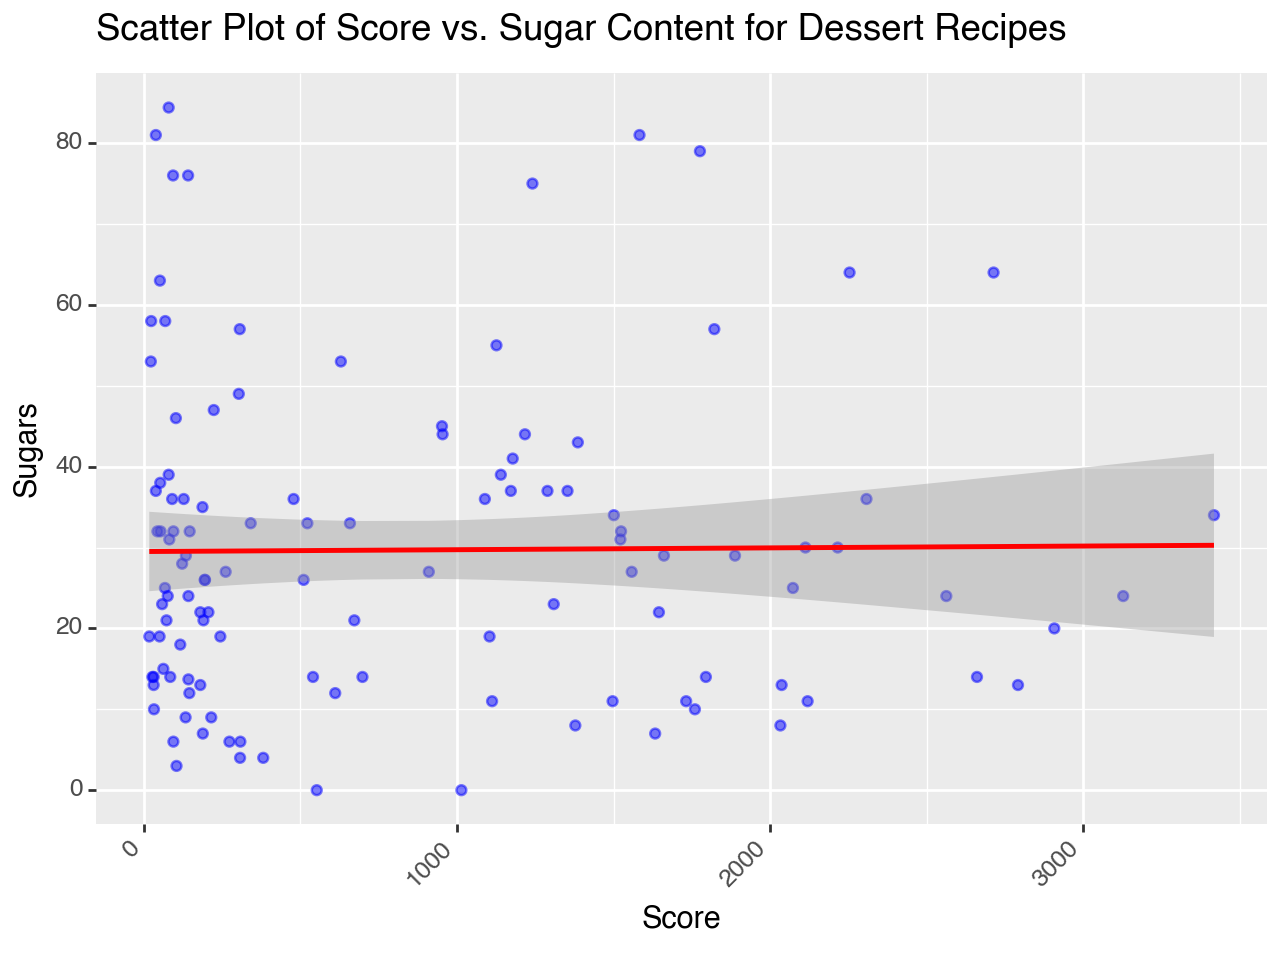

In [85]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, xlim, ylim

plot = (
    ggplot(df_desserts, aes(x='score', y='sugars')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Score vs. Sugar Content for Dessert Recipes', x='Score', y='Sugars') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 407 rows containing missing values.


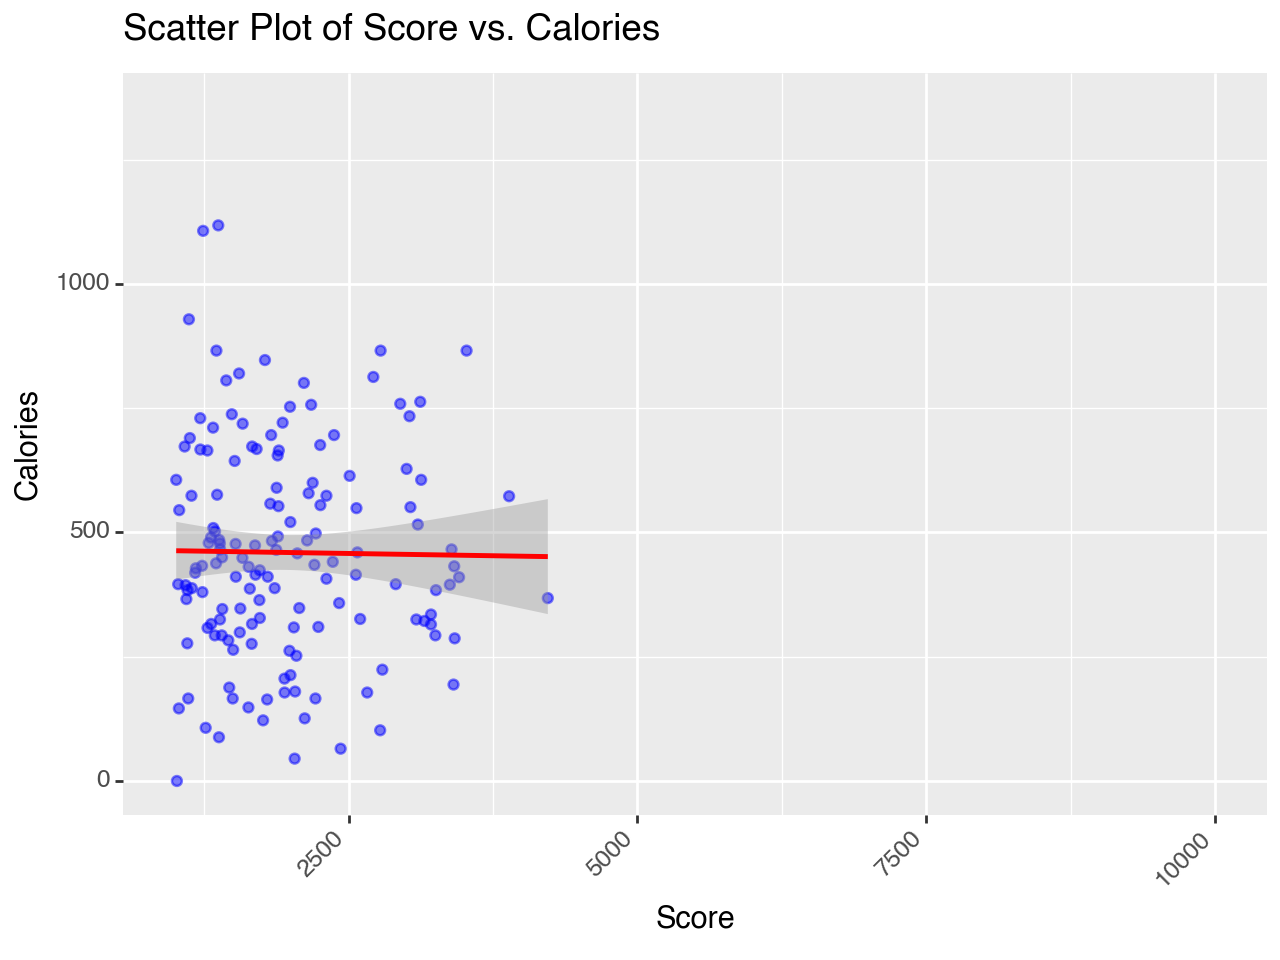

In [75]:
from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme, element_text, xlim, ylim

plot = (
    ggplot(df_for_analysis, aes(x='score', y='calories')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Score vs. Calories', x='Score', y='Calories') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + xlim(1000, 10000)
)

print(plot)